In [8]:
import sys
import os

# Get the current working directory, then step back
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Insert the parent directory into sys.path
sys.path.insert(0, parent_dir)


In [9]:
sys.path

['c:\\Users\\DivyaPrakash\\Documents\\Divya\\Stock_Market_prediction\\StockAnalysis',
 'c:\\Users\\DivyaPrakash\\Documents\\Divya\\Stock_Market_prediction\\StockAnalysis\\notebooks',
 'c:\\Users\\DivyaPrakash\\anaconda3\\python311.zip',
 'c:\\Users\\DivyaPrakash\\anaconda3\\DLLs',
 'c:\\Users\\DivyaPrakash\\anaconda3\\Lib',
 'c:\\Users\\DivyaPrakash\\anaconda3',
 '',
 'c:\\Users\\DivyaPrakash\\anaconda3\\Lib\\site-packages',
 'c:\\Users\\DivyaPrakash\\anaconda3\\Lib\\site-packages\\win32',
 'c:\\Users\\DivyaPrakash\\anaconda3\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\DivyaPrakash\\anaconda3\\Lib\\site-packages\\Pythonwin']

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime,timedelta
from src import stock_info as si
import joblib


In [12]:
#plot historical data.
start_date = datetime(2010, 1, 1) 
end_date = datetime.today().date()
ticker = "LEMONTREE.NS"

historical_data = si.get_historical_data(start_date=start_date, end_date=end_date, ticker=ticker)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

data shape check:(1732, 5)


In [13]:
historical_data.index.min(),historical_data.index.max()

(Timestamp('2018-04-09 00:00:00'), Timestamp('2025-04-11 00:00:00'))

In [14]:
data = historical_data[[f'Close_{ticker}']]

In [15]:
data.head()

,Close_LEMONTREE.NS
Date,
2018-04-09,71.650002
2018-04-10,66.849998
2018-04-11,66.949997
2018-04-12,66.400002
2018-04-13,67.699997


In [16]:
#calculate moving avg 
data['MAS'] = data[f'Close_{ticker}'].rolling(window=5).mean()
data['MAS20'] = data[f'Close_{ticker}'].rolling(window=20).mean()

C:\Users\DivyaPrakash\AppData\Local\Temp\ipykernel_23156\218091804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MAS'] = data[f'Close_{ticker}'].rolling(window=5).mean()
C:\Users\DivyaPrakash\AppData\Local\Temp\ipykernel_23156\218091804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MAS20'] = data[f'Close_{ticker}'].rolling(window=20).mean()


In [17]:
# Drop NaN values (caused by the moving averages)
data = data.dropna()

In [18]:
#Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [19]:
#create a time step data structure 
def create_dataset(data, time_step=60):
    X,y = [],[]
    for i in range(time_step, len(data)):
       
        X.append(data[i-time_step:i,:])
        y.append(data[i,0])

    return np.array(X), np.array(y)

In [20]:
#Preparing data for training (using 60 days for predicting the nest day's price)
X,y = create_dataset(scaled_data, time_step=60)

#Reshape the data for LSTM [Samples, time steps , features]
X = X.reshape(X.shape[0], X.shape[1],X.shape[2])

#split the data into the training an test sets(80% Train and 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

#convert to pytorch Tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


Define the LSTM Model in Pytorch

In [21]:
class StockPricePredictor(nn.Module):
    def __init__(self, input_size=3, hidden_layer_size = 100, num_layers=2, output_size=1):
        super(StockPricePredictor, self).__init__()

        #LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        #Dropout layer
        self.dropout = nn.Dropout(0.2)

        #fully Connected Layer
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        out,_ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:,-1,:])
        return out

In [22]:
#initialize the model, Define Loss and optimiser 
model = StockPricePredictor(input_size=3, hidden_layer_size=100, num_layers=2,output_size=1)

#Loss Funtion (Mean Squared Error)
criterion = nn.MSELoss()

#Optimiser(Adam)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

train The Model

In [ ]:
#set the number of epochs
epochs = 100

for epoch in range(epochs):
    #forward pass
    outputs = model(X_train_tensor)

    #calculate loss
    loss = criterion(outputs, y_train_tensor.view(-1,1))

    #apply backpropoagation and optimization
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if (epoch + 1)%5 == 0: #print Every 2 epochs 
        print(f"Epochs[{epoch+1}/{epochs}], Loss:{loss.item():.4f}")

Epochs[5/100], Loss:0.0529
Epochs[10/100], Loss:0.0335
Epochs[15/100], Loss:0.0197


Evaluate the Model and Make Prediction for the Test Data

(array([19723., 19783., 19844., 19905., 19967., 20028., 20089., 20148.,
        20209.]),
 [Text(19723.0, 0, '2024-01'),
  Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03'),
  Text(20209.0, 0, '2025-05')])

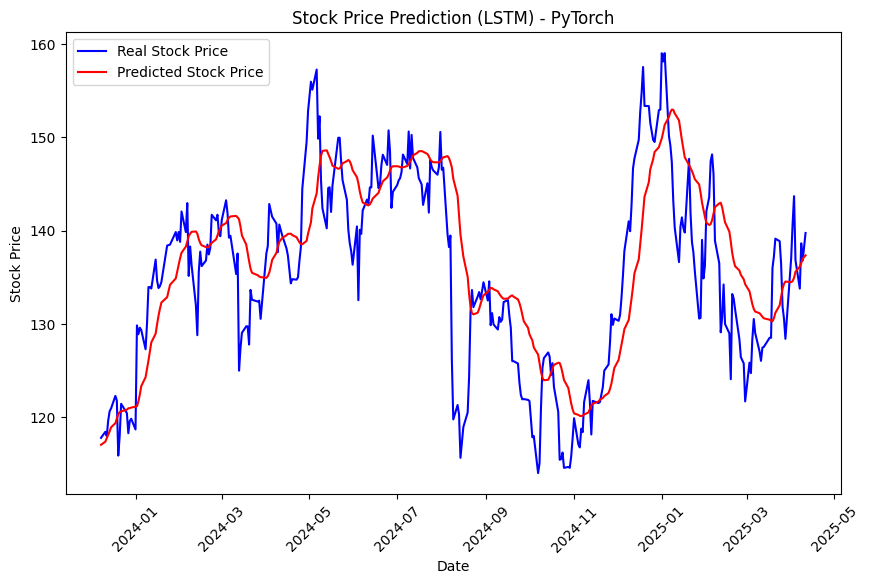

In [ ]:
model.eval() # set the model to evaluation mode

with torch.no_grad():
    predicited_price = model(X_test_tensor)

# convert prediction and true values back to the original scale
predicited_price = predicited_price.numpy()
real_price = y_test_tensor.numpy().reshape(-1,1)

#Inverse scalling on all the featurees
predicted_price_all_features = np.concatenate([predicited_price, np.zeros((predicited_price.shape[0],2))], axis = 1)
real_price_all_features = np.concatenate([real_price, np.zeros((real_price.shape[0],2))], axis =1)

#inverse the scalling to get the actual pricing
predicted_price_all_features = scaler.inverse_transform(predicted_price_all_features)
real_price_all_features = scaler.inverse_transform(real_price_all_features)

predicited_price_final = predicted_price_all_features[:,0]
real_price_final = real_price_all_features[:,0]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(real_price_final):], real_price_final, color='blue', label='Real Stock Price')
plt.plot(data.index[-len(predicited_price_final):], predicited_price_final, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction (LSTM) - PyTorch')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)


(738, 1)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(real_price, predicited_price))
print(f'RMSE: {rmse}')


RMSE: 0.04671204574668799


In [ ]:
#Save the trained model 
# Save the trained model
torch.save(model.state_dict(), 'stock_price_predictor.pth')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

print("Model and Scaler saved successfully.")

Model and Scaler saved successfully.


Predict the price for tommorow

In [ ]:
def predict_stock_price():
    #plot historical data.
    end_date = datetime.today()
    start_date = end_date - timedelta(days=60) 
    ticker = "SBIN.NS"

    data = si.get_historical_data(start_date=start_date, end_date=end_date, ticker=ticker)
    data = data['Close_SBIN.NS']
    #calculate moving avg 
    data['MAS'] = data['Close_SBIN.NS'].rolling(window=5).mean()
    data['MAS20'] = data['Close_SBIN.NS'].rolling(window=20).mean()
    data.dropna(inplace=True)
    
    scaled_data = scaler.fit_transform(data)
    input_tensor = torch.tensor(scaled_data, dtype=torch.float32)
    model.eval() # set the model to evaluation mode

    with torch.no_grad():
        predicited_price = model(input_tensor)

    # convert prediction and true values back to the original scale
    predicited_price = predicited_price.numpy()
    
    #Inverse scalling on all the featurees
    predicted_price_all_features = np.concatenate([predicited_price, np.zeros((predicited_price.shape[0],2))], axis = 1)
    #inverse the scalling to get the actual pricing
    predicted_price_all_features = scaler.inverse_transform(predicted_price_all_features)

    predicited_price_final = predicted_price_all_features[:,0]
    return predicited_price_final

In [194]:
predict_stock_price()

[*********************100%***********************]  1 of 1 completed


KeyError: 'Close_SBIN.NS'

In [177]:
datetime(2010, 1, 1)

datetime.datetime(2010, 1, 1, 0, 0)